# Finetune EfficientNet-B5


## efficientnetb5_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb5_1080repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b5(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 456x456, suitable for EfficientNet-B5
    transforms.Resize((456, 456)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_33956\2770681902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=64,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 149/149 [01:00<00:00,  2.47it/s, Loss=0.18658384680747986, Elapsed=71.3554s, ETA=0.0000s]


Epoch 1 completed in 522.0835s
Train Loss: 0.9037554440467299 - Train Accuracy: 62.947468397367764
Validation Loss: 0.7679746597005217 - Validation Accuracy: 69.30139299282398

Epoch 2/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.028156904503703117, Elapsed=70.5545s, ETA=0.0000s]


Epoch 2 completed in 520.4823s
Train Loss: 0.6586138330475466 - Train Accuracy: 73.30001582958323
Validation Loss: 0.6590033973498433 - Validation Accuracy: 73.3642887294217

Epoch 3/50


Validating: 100%|██████████| 149/149 [01:00<00:00,  2.48it/s, Loss=0.0048942044377326965, Elapsed=71.1960s, ETA=0.0000s]


Epoch 3 completed in 521.0577s
Train Loss: 0.5332570603675332 - Train Accuracy: 78.46045996246127
Validation Loss: 0.6618280221251833 - Validation Accuracy: 72.6572393414943

EarlyStopping counter: 1/5
Epoch 4/50


Validating: 100%|██████████| 149/149 [01:00<00:00,  2.46it/s, Loss=0.01177328359335661, Elapsed=71.6241s, ETA=0.0000s] 


Epoch 4 completed in 521.7488s
Train Loss: 0.4398142308988723 - Train Accuracy: 82.20528708079871
Validation Loss: 0.645375262439601 - Validation Accuracy: 80.1815111861545

Epoch 5/50


Validating: 100%|██████████| 149/149 [01:00<00:00,  2.48it/s, Loss=0.01754201203584671, Elapsed=71.0046s, ETA=0.0000s] 


Epoch 5 completed in 520.7328s
Train Loss: 0.359193049489848 - Train Accuracy: 85.0139074195518
Validation Loss: 0.6945645139621408 - Validation Accuracy: 79.22119037568595

EarlyStopping counter: 1/5
Epoch 6/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.005223205778747797, Elapsed=70.8272s, ETA=0.0000s]


Epoch 6 completed in 520.9039s
Train Loss: 0.2749825637846883 - Train Accuracy: 88.07353972094705
Validation Loss: 0.850561350324635 - Validation Accuracy: 79.15787252005066

EarlyStopping counter: 2/5
Epoch 7/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.002746014855802059, Elapsed=70.8582s, ETA=0.0000s]


Epoch 7 completed in 520.8115s
Train Loss: 0.21742176915237252 - Train Accuracy: 90.32586327762827
Validation Loss: 1.0163421880816352 - Validation Accuracy: 78.83073026593499

EarlyStopping counter: 3/5
Epoch 8/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=1.2081040040357038e-05, Elapsed=70.5410s, ETA=0.0000s]


Epoch 8 completed in 520.4118s
Train Loss: 0.17371346611750627 - Train Accuracy: 92.26611790778138
Validation Loss: 0.9039342908196074 - Validation Accuracy: 79.31616715913887

EarlyStopping counter: 4/5
Epoch 9/50


Validating: 100%|██████████| 149/149 [01:00<00:00,  2.46it/s, Loss=0.0015485788462683558, Elapsed=71.4253s, ETA=0.0000s]

Epoch 9 completed in 521.7130s
Train Loss: 0.14341249870467937 - Train Accuracy: 93.7066099816829
Validation Loss: 1.0086369200808076 - Validation Accuracy: 79.93879273955255

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


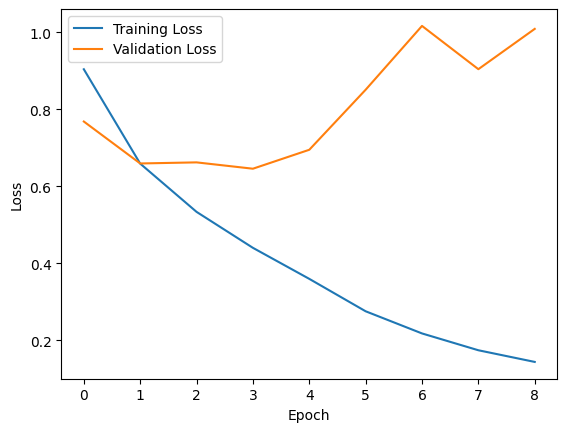

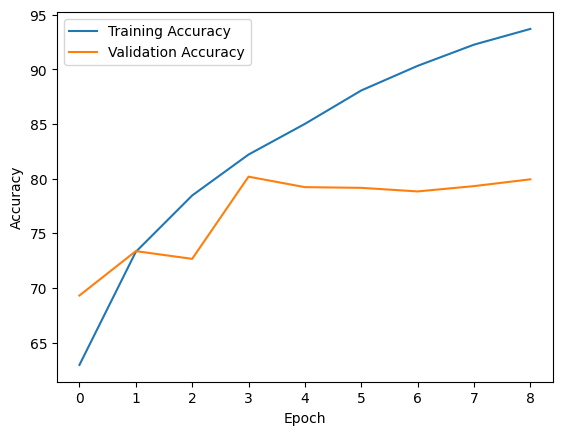

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 149/149 [01:12<00:00,  2.05it/s]


Test Accuracy: 0.7960
Test Precision: 0.8025
Test Recall: 0.7960
Test F1-score: 0.7969

              precision    recall  f1-score   support

       Anger       0.82      0.80      0.81       916
       Bored       0.86      0.89      0.87      1098
     Disgust       0.72      0.52      0.60       291
        Fear       0.48      0.71      0.57       308
       Happy       0.85      0.74      0.79      1914
     Neutral       0.73      0.79      0.76      2226
    Question       0.89      0.92      0.90      1139
         Sad       0.84      0.77      0.80       857
    Surprise       0.80      0.79      0.79       728

    accuracy                           0.80      9477
   macro avg       0.77      0.77      0.77      9477
weighted avg       0.80      0.80      0.80      9477



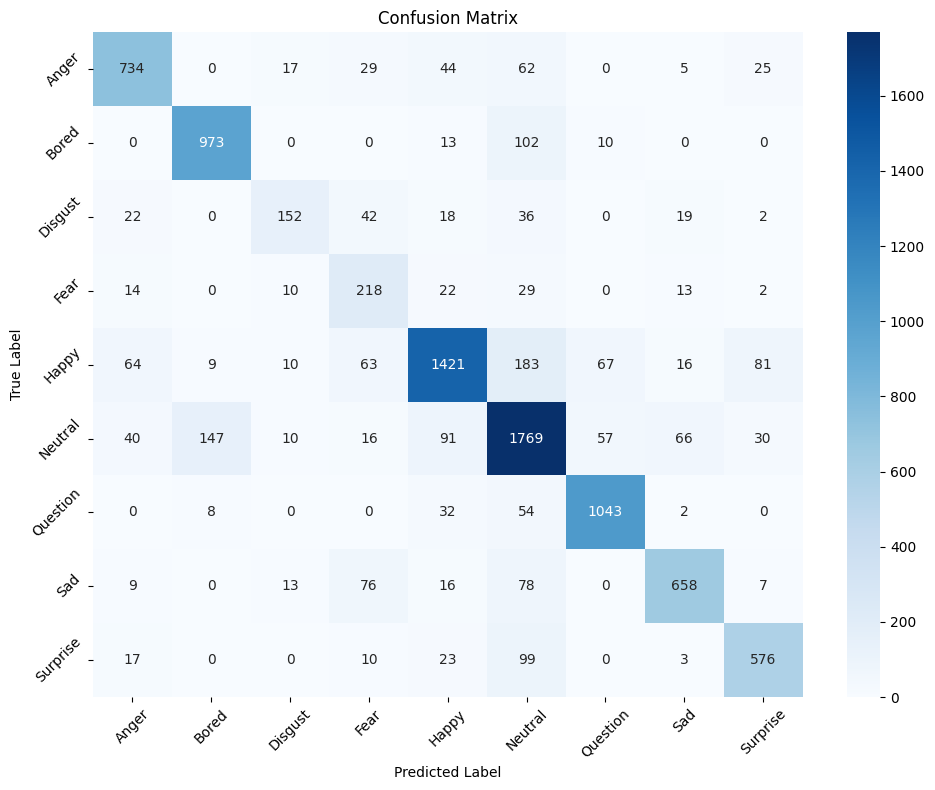

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)